# Physical Activity Tweet classification with deep learning and large language models

In [ ]:
!pip -q install transformers datasets evaluate sentencepiece

In [ ]:
import re

import evaluate
import numpy as np
import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from transformers import (AutoModelForSequenceClassification, AutoTokenizer,
                          DataCollatorWithPadding, GPT2Tokenizer,
                          GPTNeoForSequenceClassification, Trainer,
                          TrainingArguments,
                          XLMRobertaForSequenceClassification,
                          XLMRobertaTokenizer)

# checkpoint = "EleutherAI/gpt-neo-1.3B" # Define which pre-trained model we will be using
tokenizer = AutoTokenizer.from_pretrained("D3xter1922/electra-base-discriminator-finetuned-cola")
classifier = AutoModelForSequenceClassification.from_pretrained("D3xter1922/electra-base-discriminator-finetuned-cola")

# Data loading and preprocessing

In [ ]:
# Load the training data
text_file = 'train.txt'
label_file = 'WN23_PA_training_labels.txt'

text_df = pd.read_csv(text_file, sep = ",",encoding = "ISO-8859-1")
label_df = pd.read_csv(label_file, sep = ",", encoding = "ISO-8859-1")
# print(text_df.head())
label_df = label_df['Label']

def regex_preprocessing(text: str) -> str:
     """
     Removes:
     1. URL links
     2. line break (\n) characters
     3. whitespace characters (&amp;)
     4. @username
     5. Substitute w/ --> "with", @  --> "at" (not accounting for username)
     6. Character normalization (e.g., todddaayyy --> today)

     Args:
         text (str): string to be preprocessed

     Returns:
         str: a cleaned text
     """
     url = r"(?:http|https):\/\/[a-zA-Z0-9]*\.[a-zA-Z0-9]*\/[a-zA-Z0-9]*\/[a-zA-Z0-9]*|(?:http|https):\/\/t\.co\/[a-zA-Z0-9]*|(?:http|https):\/\/[a-zA-Z0-9]*\.[a-zA-Z0-9]*\/[a-zA-Z0-9]*"
     linebreak = r"\n"
     username = r"@[a-zA-Z0-9_]*(?! )"
     otherchar = r"(?:&amp;|#|_{2,}|\.{2,}|\\n|\\)"
     charnorm = r"([A-Za-z])\1{2,}"
     w = r"w\/" # about
     at = r"@ " # about 204 occurences

     text = re.sub(url, '', text)
     text = re.sub(linebreak, '', text)
     text = re.sub(username, '', text)
     text = re.sub(otherchar, '', text)
     text = re.sub(w, "with ", text)
     text = re.sub(at, "at ", text)
     text = re.sub(charnorm, r"\1", text)

     return text

text_df['Tweet'] = text_df['Tweet'].apply(lambda x: regex_preprocessing(x)).apply(lambda x: "".join(x))
text_df

,TweetID,TimeOfDay,Tweet
0,1001,17,The Bulldogs have been selected to finish 4th ...
1,1002,22,Played disc golf. Got a tattoo. Heading to Det...
2,1003,16,Sunday big football game I'm gunna gather all ...
3,1004,20,Despite my resolution to be nicer to Scooter t...
4,1005,18,Reassigned by Michigan Runner to shoot Goodlif...
...,...,...,...
3995,4996,23,completed his food and exercise diary for 5/01...
3996,4997,22,It's a great feeling when all of your pants ar...
3997,4998,22,Pretty freaking excited for fishing season rig...
3998,4999,23,"Ok, now that's just funny. Õ¬ Social coaching ..."


In [ ]:
df = pd.concat([text_df, label_df], axis = 1)
df

,TweetID,TimeOfDay,Tweet,Label
0,1001,17,The Bulldogs have been selected to finish 4th ...,0
1,1002,22,Played disc golf. Got a tattoo. Heading to Det...,1
2,1003,16,Sunday big football game I'm gunna gather all ...,0
3,1004,20,Despite my resolution to be nicer to Scooter t...,0
4,1005,18,Reassigned by Michigan Runner to shoot Goodlif...,0
...,...,...,...,...
3995,4996,23,completed his food and exercise diary for 5/01...,1
3996,4997,22,It's a great feeling when all of your pants ar...,1
3997,4998,22,Pretty freaking excited for fishing season rig...,1
3998,4999,23,"Ok, now that's just funny. Õ¬ Social coaching ...",0


In [ ]:
# Split the data into train and evaluation (stratified)
df_train, df_eval = train_test_split(df, train_size=0.8,stratify=df.Label, random_state=42) # Stratified splitting

# Turn pandas dataframe into dataset
We will be using Trainer API from HuggingFace for fine-tuning, and it requires data in the form of Dataset. Therefore, we will convert our Pandas DataFrame into DataSet stored in DatasetDict

In [ ]:
raw_datasets = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "eval": Dataset.from_pandas(df_eval)
})

In [ ]:
# Check the datasets
print("Dataset Dict:\n", raw_datasets)
print("\n\nTrain's features:\n", raw_datasets["train"].features)
print("\n\nFirst row of Train:\n", raw_datasets["train"][0])

Dataset Dict:
 DatasetDict({
    train: Dataset({
        features: ['TweetID', 'TimeOfDay', 'Tweet', 'Label', '__index_level_0__'],
        num_rows: 3200
    })
    eval: Dataset({
        features: ['TweetID', 'TimeOfDay', 'Tweet', 'Label', '__index_level_0__'],
        num_rows: 800
    })
})


Train's features:
 {'TweetID': Value(dtype='int64', id=None), 'TimeOfDay': Value(dtype='int64', id=None), 'Tweet': Value(dtype='string', id=None), 'Label': Value(dtype='int64', id=None), '__index_level_0__': Value(dtype='int64', id=None)}


First row of Train:
 {'TweetID': 1227, 'TimeOfDay': 16, 'Tweet': "You don't have to walk into the break room every 15 minutes checking the clock to see if we've punched in We're big kids we know when to", 'Label': 0, '__index_level_0__': 226}


# Tokenizing
Neural network require the input to be in the form of numbers for training to take place. Therefore, we will convert our text into vector of numbers (tokens) by using tokenizer.

In [ ]:
# Tokenize the text, and truncate the text if it exceed the tokenizer maximum length. Batched=True to tokenize multiple texts at the same time.
tokenized_datasets = raw_datasets.map(lambda dataset: tokenizer(dataset['Tweet'], truncation=True), batched=True)
print(tokenized_datasets)

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['TweetID', 'TimeOfDay', 'Tweet', 'Label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3200
    })
    eval: Dataset({
        features: ['TweetID', 'TimeOfDay', 'Tweet', 'Label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 800
    })
})


In [ ]:
# Check the first row
print(tokenized_datasets["train"][0])
print(tokenized_datasets["eval"][0])

{'TweetID': 1227, 'TimeOfDay': 16, 'Tweet': "You don't have to walk into the break room every 15 minutes checking the clock to see if we've punched in We're big kids we know when to", 'Label': 0, '__index_level_0__': 226, 'input_ids': [101, 2017, 2123, 1005, 1056, 2031, 2000, 3328, 2046, 1996, 3338, 2282, 2296, 2321, 2781, 9361, 1996, 5119, 2000, 2156, 2065, 2057, 1005, 2310, 11696, 1999, 2057, 1005, 2128, 2502, 4268, 2057, 2113, 2043, 2000, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'TweetID': 2448, 'TimeOfDay': 0, 'Tweet': 'Need to find someone to do my hair ASAP I refuse to walk around like this', 'Label': 0, '__index_level_0__': 1447, 'input_ids': [101, 2342, 2000, 2424, 2619, 2000, 2079, 2026, 2606, 17306, 2361, 1045, 10214, 2000, 3328, 2105, 2066, 2023, 102], 'tok

In [ ]:
# remove text and \_\_index_level_0__ as they are not needed for our model fine-tuning
tokenized_datasets = tokenized_datasets.remove_columns(["Tweet", "__index_level_0__"])

# rename "target" to "labels", as Trainer API require the target to be named "labels"
tokenized_datasets = tokenized_datasets.rename_column("Label", "labels")

print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['TweetID', 'TimeOfDay', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3200
    })
    eval: Dataset({
        features: ['TweetID', 'TimeOfDay', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 800
    })
})


# Training
We will be using Trainer API from HuggingFace for training.

In [ ]:
# Padding for batch of data that will be fed into model for training
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Training args
training_args = TrainingArguments(
    "test-trainer",
    num_train_epochs=3,
    evaluation_strategy="epoch",
    weight_decay=5e-3,
    save_strategy="no",
    report_to="none",
)


# Metric for validation error
def compute_metrics(eval_preds):
    metric = evaluate.load("glue", "mrpc")  # F1 and Accuracy
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


# Define trainer
trainer = Trainer(
    classifier,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["eval"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
# Start the fine-tuning
trainer.train()

PyTorch: setting up devices
The following columns in the training set don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: TimeOfDay, TweetID. If TimeOfDay, TweetID are not expected by `ElectraForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3200
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1200
  Number of trainable parameters = 109483778


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.676273,0.810000,0.730496
2,0.234200,0.967745,0.837500,0.760148
3,0.072900,0.996779,0.840000,0.766423


The following columns in the evaluation set don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: TimeOfDay, TweetID. If TimeOfDay, TweetID are not expected by `ElectraForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: TimeOfDay, TweetID. If TimeOfDay, TweetID are not expected by `ElectraForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: TimeOfDay, TweetID. If TimeOfDay, TweetID are not expected by `ElectraForSequenceClassification.forward`,  you can safely ignore 

TrainOutput(global_step=1200, training_loss=0.13352779587109884, metrics={'train_runtime': 84.1224, 'train_samples_per_second': 114.119, 'train_steps_per_second': 14.265, 'total_flos': 163585187559840.0, 'train_loss': 0.13352779587109884, 'epoch': 3.0})

# Quick evaluation using classification metrics
We'll be using [sklearn.metrics.classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) to do quick evaluation

In [ ]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

The following columns in the test set don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: TimeOfDay, TweetID. If TimeOfDay, TweetID are not expected by `ElectraForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 800
  Batch size = 8


              precision    recall  f1-score   support

           0      0.906     0.852     0.878       542
           1      0.724     0.814     0.766       258

    accuracy                          0.840       800
   macro avg      0.815     0.833     0.822       800
weighted avg      0.847     0.840     0.842       800

Confusion matrix, without normalization


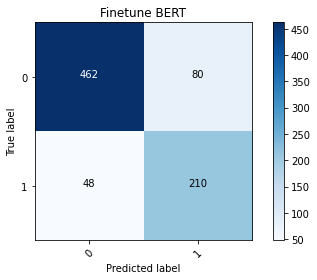

In [ ]:
from sklearn.metrics import classification_report

# Make prediction on evaluation dataset
y_pred = trainer.predict(tokenized_datasets["eval"]).predictions
y_pred = np.argmax(y_pred, axis=-1)

# Get the true labels
y_true = tokenized_datasets["eval"]["labels"]
y_true = np.array(y_true)

# Print the classification report
print(classification_report(y_true, y_pred, digits=3))
cm = confusion_matrix(y_true, y_pred, labels=classes)
plot_confusion_matrix(cm, classes=classes, title='Finetune BERT')

***

# Submission

In [ ]:
# Get the test data
sub_file = 'test.txt'
df_test = pd.read_csv(sub_file, sep = ",",encoding = "ISO-8859-1")
ids = df_test.TweetID # Save ids
df_test['Tweet'] = df_test['Tweet']
df_test = df_test.loc[:,["Tweet"]] # Keep only text

# Turn the DataFrame into appropriate format
test_dataset = Dataset.from_pandas(df_test)
test_dataset = test_dataset.map(lambda dataset: tokenizer(dataset['Tweet'], truncation=True), batched=True)
test_dataset = test_dataset.remove_columns('Tweet')

# Get the prediction
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

# Turn submission into DataFrame and save into CSV files
submission = pd.DataFrame({"TweetID":ids, "Label":preds})
submission.to_csv("submission_4.csv", index=False)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

***** Running Prediction *****
  Num examples = 1000
  Batch size = 8
